Applying Ordinal Encoding for ordinal or ordered levels

In [1]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd


df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")


ordinal_cols = ['Education', 'Income', 'GenHlth', 'MentHlth', 'PhysHlth']


encoder = OrdinalEncoder()
df[ordinal_cols] = encoder.fit_transform(df[ordinal_cols])





SMOTE+TOMEK links for class imbalance

In [4]:
from imblearn.combine import SMOTETomek
import pandas as pd


X = df.drop("Diabetes_012", axis=1)
y = df["Diabetes_012"]

# Applying the model
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)


print("Class distribution after SMOTE+Tomek:")
print(pd.Series(y_resampled).value_counts())


Class distribution after SMOTE+Tomek:
Diabetes_012
1.0    213679
0.0    213577
2.0    213559
Name: count, dtype: int64


1. Logistic Regression (Multinomial)

TRAINING METRICS 
Train Accuracy: 0.32

Train Classification Report:
               precision    recall  f1-score   support

           0       0.32      1.00      0.48       255
           1       0.33      0.00      0.01       273
           2       0.00      0.00      0.00       272

    accuracy                           0.32       800
   macro avg       0.22      0.33      0.16       800
weighted avg       0.22      0.32      0.16       800



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


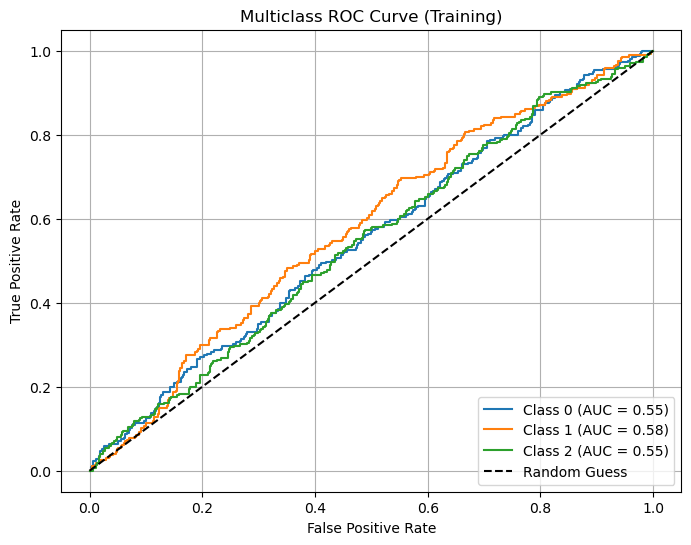

TESTING
Test Accuracy: 0.32

Test Classification Report:
               precision    recall  f1-score   support

           0       0.32      1.00      0.48        64
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        68

    accuracy                           0.32       200
   macro avg       0.11      0.33      0.16       200
weighted avg       0.10      0.32      0.16       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


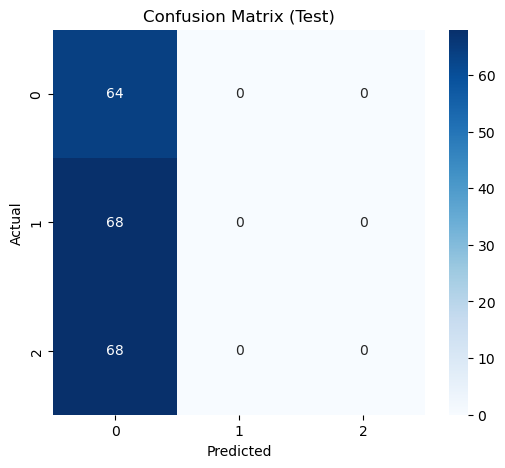

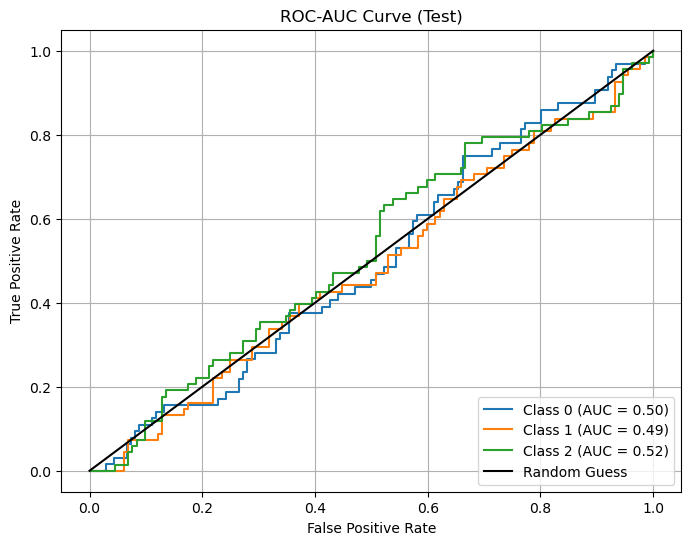

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Preprocessing dataset to apply the models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# For AUC-ROC curve generation
y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])


model = OneVsRestClassifier(
    LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
)
model.fit(X_train_scaled, y_train_bin)


y_train_pred_bin = model.predict(X_train_scaled)
y_test_pred_bin = model.predict(X_test_scaled)
y_train_pred = np.argmax(y_train_pred_bin, axis=1)
y_test_pred = np.argmax(y_test_pred_bin, axis=1)
y_train_true = np.argmax(y_train_bin, axis=1)
y_test_true = np.argmax(y_test_bin, axis=1)

#Evaluation Metrics

print("TRAINING METRICS ")
print("Train Accuracy:", accuracy_score(y_train_true, y_train_pred))
print("\nTrain Classification Report:\n", classification_report(y_train_true, y_train_pred))




y_train_score = model.predict_proba(X_train_scaled)
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(8, 6))
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_train_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("Multiclass ROC Curve (Training)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


print("TESTING")
print("Test Accuracy:", accuracy_score(y_test_true, y_test_pred))
print("\nTest Classification Report:\n", classification_report(y_test_true, y_test_pred))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test_true, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


y_test_score = model.predict_proba(X_test_scaled)
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(8, 6))
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k', label='Random Guess')
plt.title("ROC-AUC Curve (Test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Best Params: {'C': 1.0, 'max_iter': 1000, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'}

Train Accuracy: 0.37875
Test Accuracy: 0.335

Classification Report (Train):
               precision    recall  f1-score   support

           0       0.37      0.26      0.30       255
           1       0.39      0.51      0.44       273
           2       0.37      0.36      0.36       272

    accuracy                           0.38       800
   macro avg       0.38      0.38      0.37       800
weighted avg       0.38      0.38      0.37       800


Classification Report (Test):
               precision    recall  f1-score   support

           0       0.31      0.23      0.27        64
           1       0.34      0.46      0.39        68
           2       0.35      0.31      0.33        68

    accuracy                           0.34       200
   macro avg       0.33      0.33      0.33       200
weighted avg       0.33      0.34      0.33       200



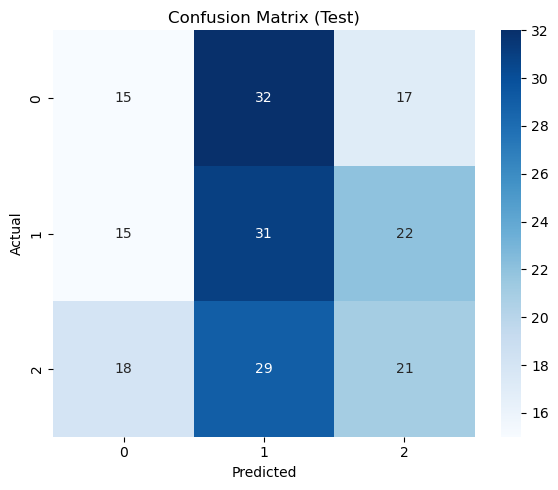

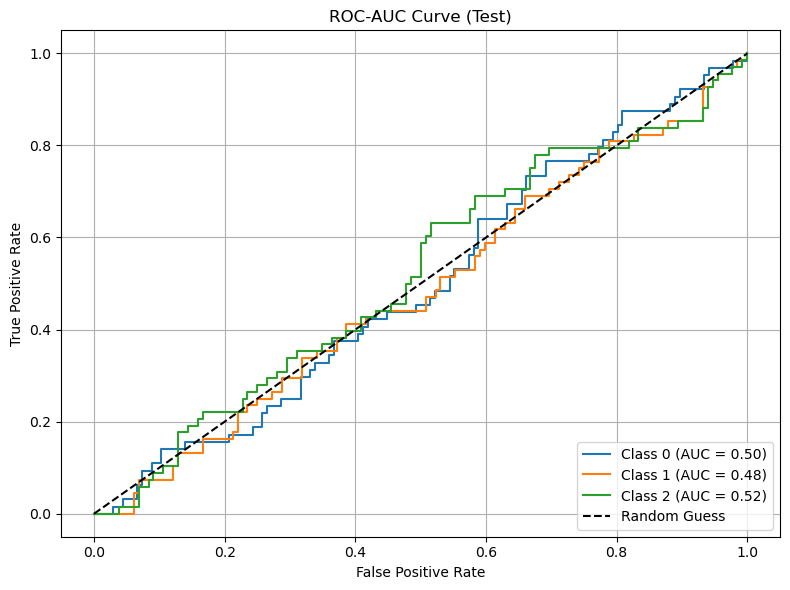

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Applying GridSearch Hyperparameter tuning
param_grid = {
    'C': [0.1, 1.0, 10],
    'penalty': ['l2'],
    'solver': ['saga'],
    'multi_class': ['multinomial'],
    'max_iter': [1000]
}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

best_model = grid.best_estimator_
print("Best Params:", grid.best_params_)


y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)
y_train_proba = best_model.predict_proba(X_train_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)


print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))


plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


y_train_bin = label_binarize(y_train, classes=[0,1,2])
y_test_bin = label_binarize(y_test, classes=[0,1,2])

fpr_train, tpr_train, roc_auc_train = {}, {}, {}
fpr_test, tpr_test, roc_auc_test = {}, {}, {}

for i in range(3):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_bin[:, i], y_train_proba[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])


plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr_test[i], tpr_test[i], label=f'Class {i} (AUC = {roc_auc_test[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("ROC-AUC Curve (Test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


2. Random Forest

Training Accuracy: 0.9932
Testing Accuracy: 0.8428

Classification Report (Train):
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    170962
         1.0       1.00      0.94      0.97      3705
         2.0       0.99      0.96      0.98     28277

    accuracy                           0.99    202944
   macro avg       0.99      0.97      0.98    202944
weighted avg       0.99      0.99      0.99    202944


Classification Report (Test):
               precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     42741
         1.0       0.00      0.00      0.00       926
         2.0       0.50      0.20      0.28      7069

    accuracy                           0.84     50736
   macro avg       0.45      0.39      0.40     50736
weighted avg       0.80      0.84      0.81     50736



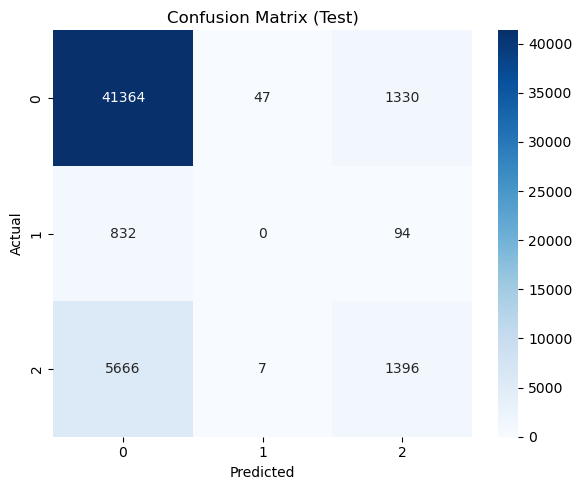


Training ROC-AUC Score: 0.9995
Testing ROC-AUC Score: 0.7394


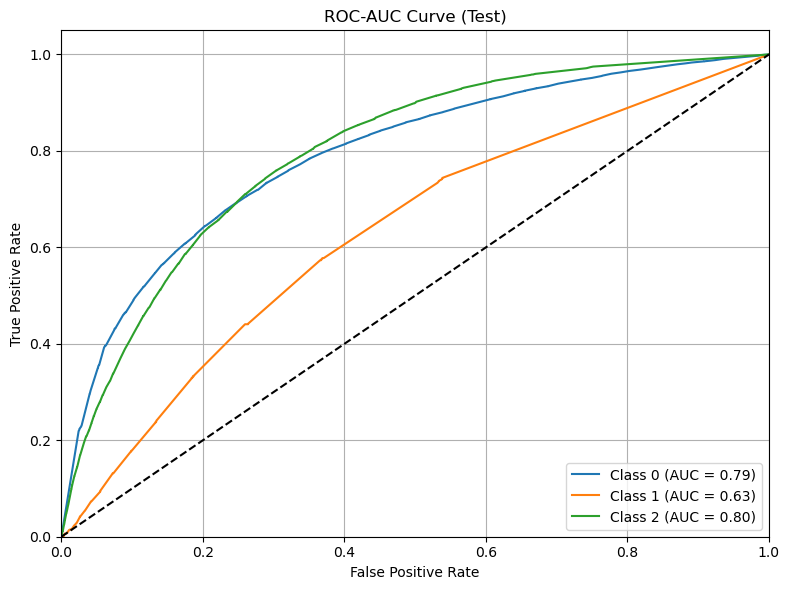

In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns


target_col = 'Diabetes_012'
X = df.drop(target_col, axis=1)
y = df[target_col]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Evaluation Metrics
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Testing Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")


print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))




plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_train_proba = rf.predict_proba(X_train)
y_test_proba = rf.predict_proba(X_test)

print(f"\nTraining ROC-AUC Score: {roc_auc_score(y_train_bin, y_train_proba, multi_class='ovr'):.4f}")
print(f"Testing ROC-AUC Score: {roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr'):.4f}")


fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_test_proba[:, i])

plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], label='Class 0 (AUC = {:.2f})'.format(roc_auc[0]))
plt.plot(fpr[1], tpr[1], label='Class 1 (AUC = {:.2f})'.format(roc_auc[1]))
plt.plot(fpr[2], tpr[2], label='Class 2 (AUC = {:.2f})'.format(roc_auc[2]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve (Test)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()




Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}

Train Accuracy: 0.9972144846796658
Test Accuracy: 0.9330774092366751

Classification Report (Train):
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    170862
         1.0       1.00      1.00      1.00    170943
         2.0       1.00      0.99      1.00    170847

    accuracy                           1.00    512652
   macro avg       1.00      1.00      1.00    512652
weighted avg       1.00      1.00      1.00    512652


Classification Report (Test):
               precision    recall  f1-score   support

         0.0       0.88      0.95      0.91     42715
         1.0       0.99      0.97      0.98     42736
         2.0       0.94      0.87      0.91     42712

    accuracy                           0.93    128163
   macro avg       0.94      0.93      0.93    128163
weighted avg   

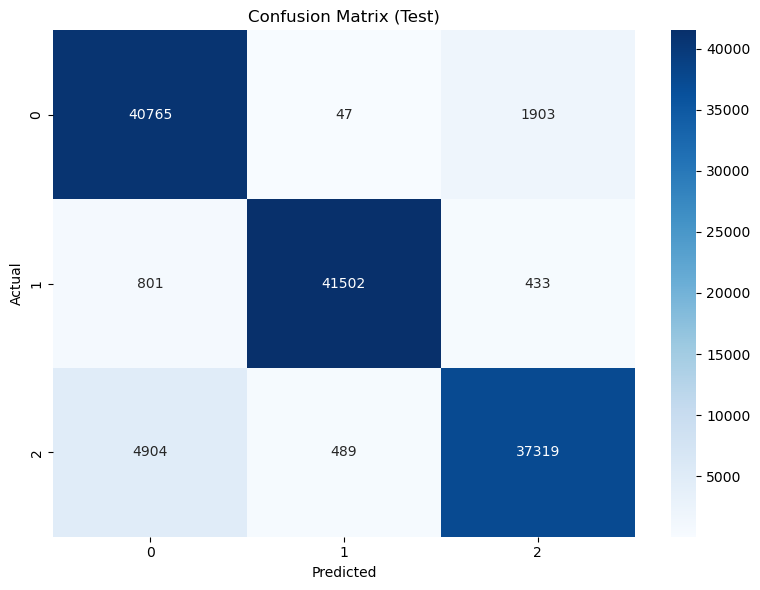

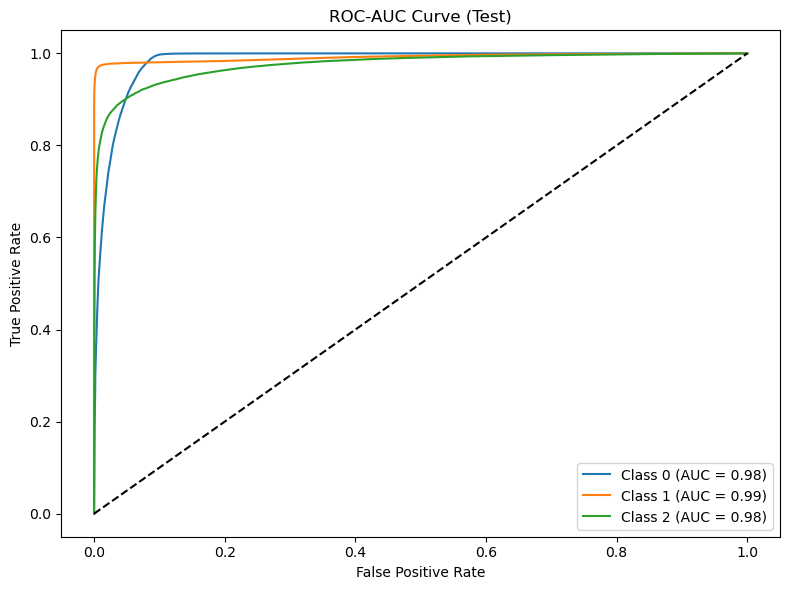

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize


X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


# Hyperparameter Tuning 

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)
y_train_proba = best_rf.predict_proba(X_train)
y_test_proba = best_rf.predict_proba(X_test)


# Evaluation Metrics

print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))


plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_test_proba[:, i])

# Plot
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC-AUC Curve (Test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


3.Support Vector Machine (SVM)


Training Accuracy: 0.3688
Testing Accuracy: 0.3250

Classification Report (Train):
               precision    recall  f1-score   support

           0       0.35      0.16      0.22       255
           1       0.38      0.53      0.44       273
           2       0.36      0.40      0.38       272

    accuracy                           0.37       800
   macro avg       0.36      0.36      0.35       800
weighted avg       0.36      0.37      0.35       800

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.34      0.17      0.23        64
           1       0.34      0.50      0.40        68
           2       0.30      0.29      0.30        68

    accuracy                           0.33       200
   macro avg       0.33      0.32      0.31       200
weighted avg       0.33      0.33      0.31       200



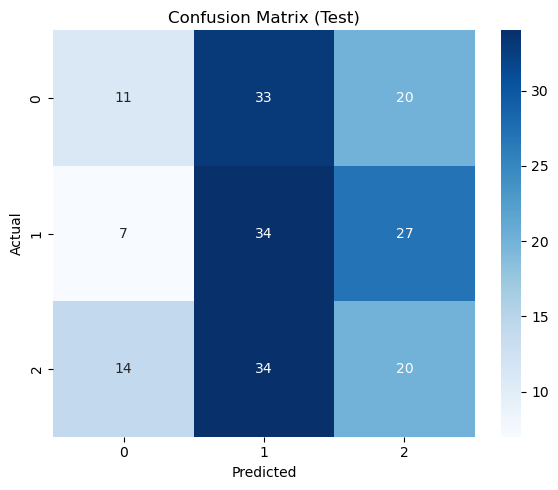

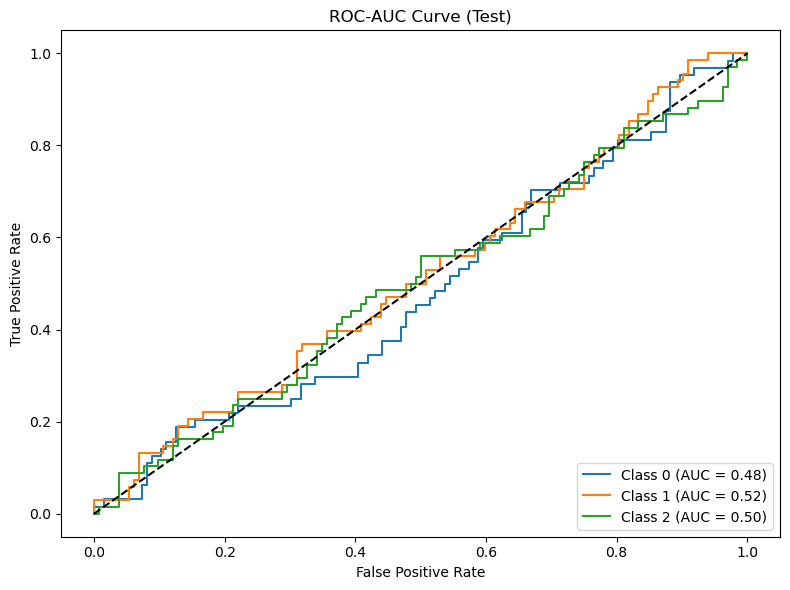

In [62]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns


X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)


y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)
y_train_proba = svm_model.predict_proba(X_train)
y_test_proba = svm_model.predict_proba(X_test)

# Evaluation Metrics
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Testing Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")


print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred))
print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))


plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])


fpr_train, tpr_train, roc_auc_train = {}, {}, {}
for i in range(3):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_bin[:, i], y_train_proba[:, i])
    roc_auc_train[i] = roc_auc_score(y_train_bin[:, i], y_train_proba[:, i])


fpr_test, tpr_test, roc_auc_test = {}, {}, {}
for i in range(3):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc_test[i] = roc_auc_score(y_test_bin[:, i], y_test_proba[:, i])



plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr_test[i], tpr_test[i], label=f'Class {i} (AUC = {roc_auc_test[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC-AUC Curve (Test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Training Accuracy: 0.38125
Test Accuracy: 0.34

Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      0.00      0.01       255
           1       0.39      0.60      0.47       273
           2       0.37      0.51      0.43       272

    accuracy                           0.38       800
   macro avg       0.59      0.37      0.30       800
weighted avg       0.58      0.38      0.31       800


Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      0.02      0.03        64
           1       0.33      0.54      0.41        68
           2       0.34      0.44      0.38        68

    accuracy                           0.34       200
   macro avg       0.56      0.33      0.28       200
weighted avg       0.55      0.34      0.28       200

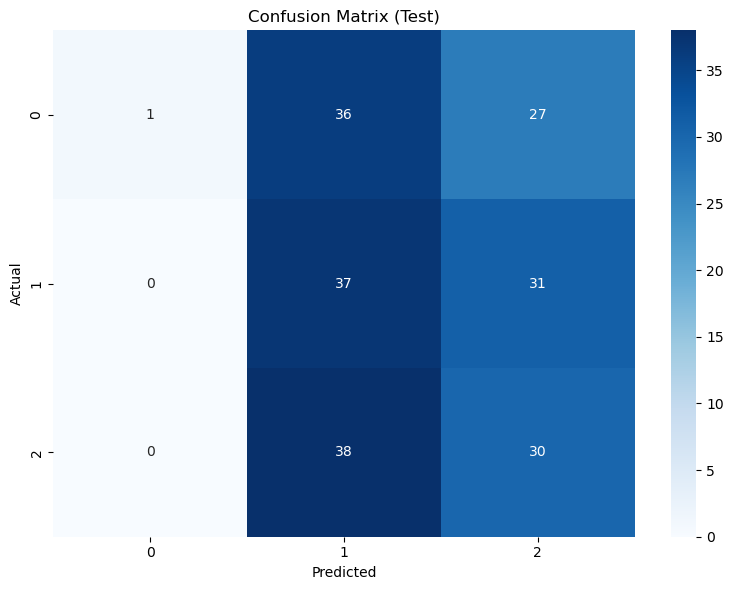

Training ROC-AUC Score: 0.4411227413802032
Testing ROC-AUC Score: 0.4990193757427213


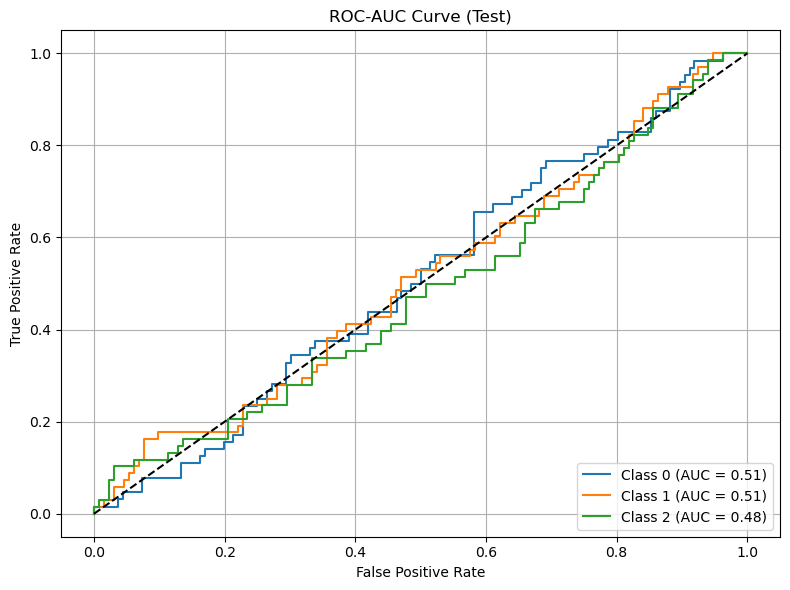

In [64]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns


X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(
    SVC(probability=True), 
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_svm = grid_search.best_estimator_

#Evaluations

print("Best Parameters:", grid_search.best_params_)


y_train_pred = best_svm.predict(X_train)
y_test_pred = best_svm.predict(X_test)
y_train_proba = best_svm.predict_proba(X_train)
y_test_proba = best_svm.predict_proba(X_test)


print("\nTraining Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))


plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])


print("Training ROC-AUC Score:", roc_auc_score(y_train_bin, y_train_proba, multi_class='ovr'))
print("Testing ROC-AUC Score:", roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr'))


fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_test_proba[:, i])

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC-AUC Curve (Test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


4. Gradient Boosting (XGBOOST)

In [28]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:55:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training Accuracy: 0.8597
Testing Accuracy: 0.8487

Classification Report (Train):
               precision    recall  f1-score   support

         0.0       0.87      0.98      0.92    170962
         1.0       1.00      0.02      0.03      3705
         2.0       0.66      0.23      0.34     28277

    accuracy                           0.86    202944
   macro avg       0.84      0.41      0.43    202944
weighted avg       0.84      0.86      0.83    202944


Classification Report (Test):
               precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     42741
         1.0       0.00      0.00      0.00       926
         2.0       0.54      0.19      0.28      7069

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736



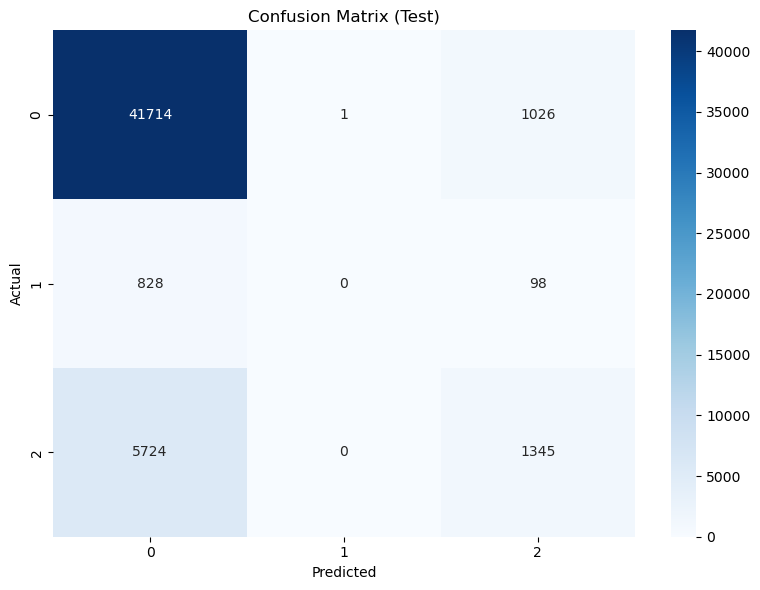

Training ROC-AUC Score: 0.8411
Testing ROC-AUC Score: 0.7811


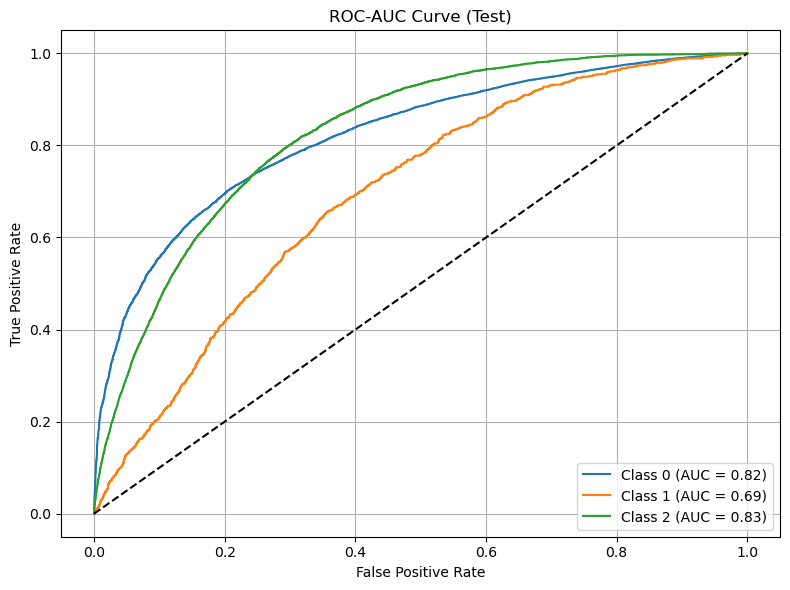

In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns



target_col = 'Diabetes_012'
X = df.drop(target_col, axis=1)
y = df[target_col]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)


y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)
y_train_proba = xgb_model.predict_proba(X_train)
y_test_proba = xgb_model.predict_proba(X_test)

# Evaluation Metrics
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Testing Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")


print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))


plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

print(f"Training ROC-AUC Score: {roc_auc_score(y_train_bin, y_train_proba, multi_class='ovr'):.4f}")
print(f"Testing ROC-AUC Score: {roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr'):.4f}")


fpr, tpr, roc_auc = {}, {}, {}
plt.figure(figsize=(8, 6))
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_test_proba[:, i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC-AUC Curve (Test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:16:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:16:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:16:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:16:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}

Training Accuracy: 0.8502345474613686
Testing Accuracy: 0.8490815200252286

Classification Report (Train):
               precision    recall  f1-score   support

         0.0       0.86      0.98      0.92    170962
         1.0       0.00      0.00      0.00      3705
         2.0       0.59      0.15      0.24     28277

    accuracy                           0.85    202944
   macro avg       0.48      0.38      0.39    202944
weighted avg       0.81      0.85      0.81    202944


Classification Report (Test):
               precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     42741
         1.0       0.00      0.00      0.00       926
         2.0       0.57      0.15      0.23      7069

    accuracy                           0.85     50736
   macro avg       0.48      0.38      0.38     50736
weighted avg       0.80      0.85      0.81     50736



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa

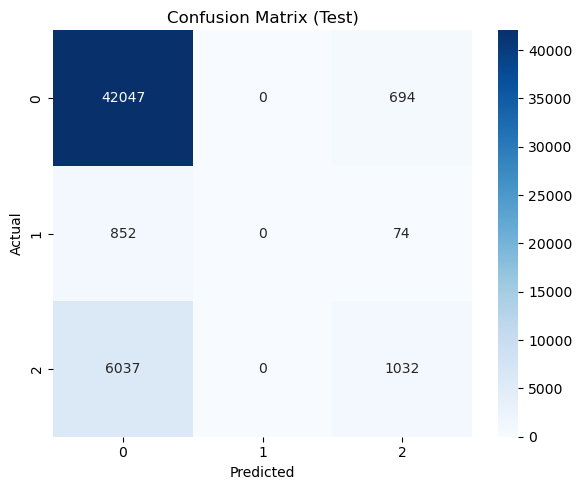


Training ROC-AUC Score: 0.9579
Testing ROC-AUC Score: 0.9566


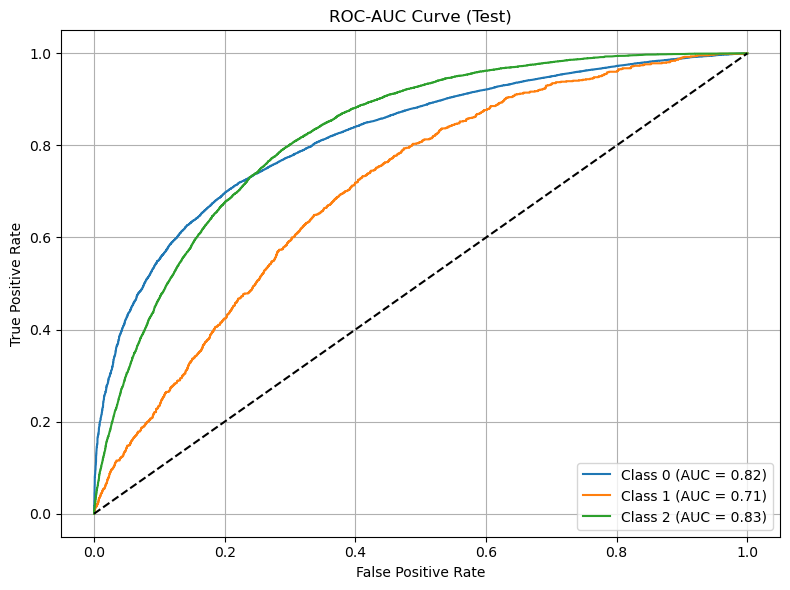

In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns




X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
#Evaluation Metrics

print("Best Parameters:", grid_search.best_params_)


y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
y_train_proba = best_model.predict_proba(X_train)
y_test_proba = best_model.predict_proba(X_test)


print("\nTraining Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))


plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

train_auc = roc_auc_score(y_train_bin, y_train_proba, average='micro')
test_auc = roc_auc_score(y_test_bin, y_test_proba, average='micro')

print(f"\nTraining ROC-AUC Score: {train_auc:.4f}")
print(f"Testing ROC-AUC Score: {test_auc:.4f}")


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_test_proba[:, i])

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve (Test)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


5. Multilayer Perceptron (MLP)

Training Accuracy: 1.0
Testing Accuracy: 0.865

Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       263
           1       1.00      1.00      1.00       266
           2       1.00      1.00      1.00       271

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800


Classification Report (Test):
               precision    recall  f1-score   support

           0       0.88      0.89      0.89        66
           1       0.82      0.91      0.86        66
           2       0.90      0.79      0.84        68

    accuracy                           0.86       200
   macro avg       0.87      0.87      0.86       200
weighted avg       0.87      0.86      0.86       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


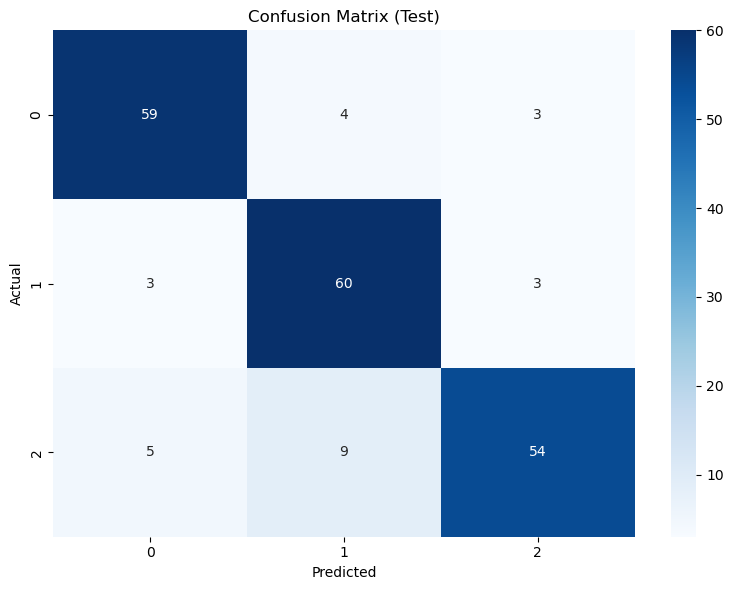


Training ROC-AUC Score: 1.0000
Testing ROC-AUC Score: 0.9589


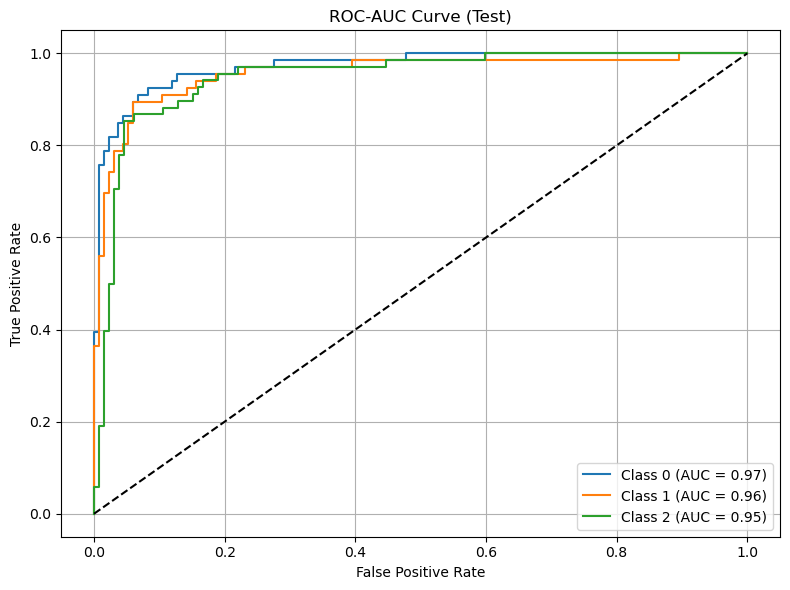

In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


mlp_model = MLPClassifier(random_state=42, max_iter=300)
mlp_model.fit(X_train, y_train)


y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
y_train_proba = mlp_model.predict_proba(X_train)
y_test_proba = mlp_model.predict_proba(X_test)

# Evaluation Metrics
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))


plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
roc_auc_train = roc_auc_score(y_train_bin, y_train_proba)
roc_auc_test = roc_auc_score(y_test_bin, y_test_proba)
print(f"\nTraining ROC-AUC Score: {roc_auc_train:.4f}")
print(f"Testing ROC-AUC Score: {roc_auc_test:.4f}")


fpr, tpr, _ = {}, {}, {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_test_proba[:, i])

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC-AUC Curve (Test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
Training Accuracy: 1.0
Testing Accuracy: 0.85

Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       263
           1       1.00      1.00      1.00       266
           2       1.00      1.00      1.00       271

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800


Classification Report (Test):
               precision    recall  f1-score   support

           0       0.84      0.89      0.87        66
           1       0.88      0.80      0.84        66
           2       0.83      0.85      0.84        68

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85      

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


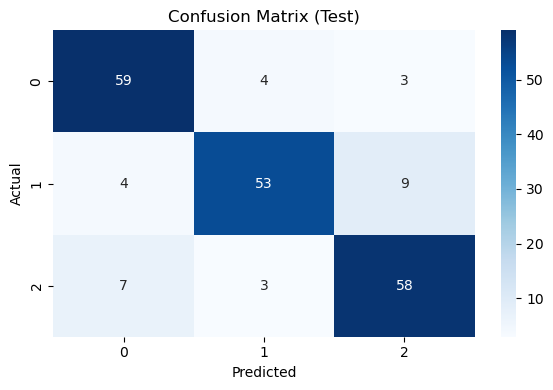

Training ROC-AUC Score: 1.0000
Testing ROC-AUC Score: 0.9597


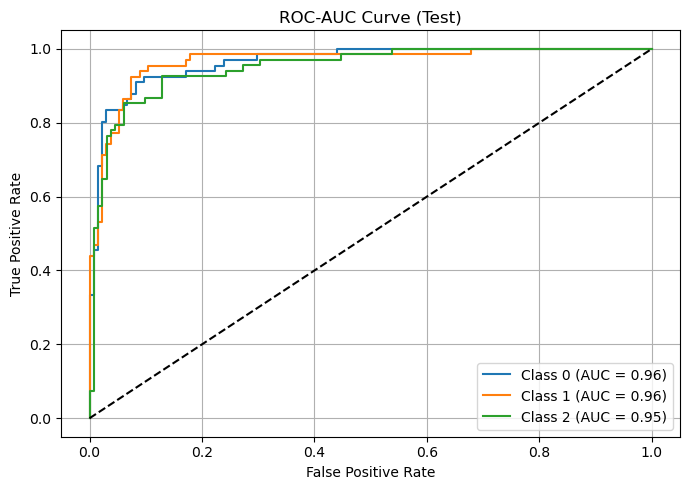

In [93]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}


grid_search = GridSearchCV(
    MLPClassifier(max_iter=500, random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_mlp = grid_search.best_estimator_


y_train_pred = best_mlp.predict(X_train)
y_test_pred = best_mlp.predict(X_test)
y_train_proba = best_mlp.predict_proba(X_train)
y_test_proba = best_mlp.predict_proba(X_test)

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


y_train_bin = label_binarize(y_train, classes=np.unique(y))
y_test_bin = label_binarize(y_test, classes=np.unique(y))
roc_auc_train = roc_auc_score(y_train_bin, y_train_proba)
roc_auc_test = roc_auc_score(y_test_bin, y_test_proba)

print(f"Training ROC-AUC Score: {roc_auc_train:.4f}")
print(f"Testing ROC-AUC Score: {roc_auc_test:.4f}")


fpr, tpr, roc_auc = {}, {}, {}
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_test_proba[:, i])

plt.figure(figsize=(7, 5))
for i in range(len(roc_auc)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC-AUC Curve (Test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
